Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Exploring time step limiters for P3M: tuning $\eta$

## Set up the environment and parameters

In [1]:
# pyright: reportWildcardImportFromLibrary=false
from wip3m import *

In [2]:
workdir = ROOT_PATH + "results/"
output_path = OUTPUT_PATH

# STANDARD PARAMETERS:
L = 64  # Box size in Mpc/h
N = 32  # Density grid size
Np = 32  # Number of dark matter particles per spatial dimension
Npm = 64  # PM grid size
n_Tiles = 8  # Make sure Npm/n_Tiles >= 6
    
force = force_hard = True
run_id = "notebook7"

In [ ]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.field import read_field
from pysbmy.timestepping import StandardTimeStepping, P3MTimeStepping

from wip3m.tools import get_k_max, generate_sim_params, generate_white_noise_Field, run_simulation
from wip3m.params import params_CONCEPT_kmax_missing, cosmo_small_to_full_dict, z2a, BASELINE_SEEDPHASE
from wip3m.plot_utils import *  # type: ignore

In [4]:
corner = 0.0
RedshiftLPT = 19.0
RedshiftFCs = 0.0

ai = z2a(RedshiftLPT)
af = z2a(RedshiftFCs)
k_max = get_k_max(L, N)  # k_max in h/Mpc
print(f"k_max = {k_max}")
# cosmo = params_planck_kmax_missing.copy()
cosmo = params_CONCEPT_kmax_missing.copy()
cosmo["k_max"] = k_max

wd = workdir + run_id + "/"
simdir = output_path + run_id + "/"
logdir = simdir + "logs/"
if force_hard:
    import shutil
    if Path(simdir).exists():
        shutil.rmtree(simdir)
    if Path(wd).exists():
        shutil.rmtree(wd)
Path(wd).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

input_white_noise_file = simdir + "input_white_noise.h5"
input_seed_phase_file = simdir + "seed"
ICs_path = simdir + "initial_density.h5"
simpath = simdir

# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

# Paths to the time step logs
OutputTimestepsLog = simdir + "timesteps_log.txt"

k_max = 2.721


### Generate the parameter files

In [5]:
common_params = {
    "Np": Np,
    "N": N,
    "L": L,
    "corner0": corner,
    "corner1": corner,
    "corner2": corner,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file
lpt_params["ICsMode"] = 1
lpt_params["InputWhiteNoise"] = input_white_noise_file

fac_dyn = DEFAULT_FAC_DYN_CUSTOM_COLA
da_early = DEFAULT_DA_MAX_EARLY_CUSTOM
fac_hubble = DEFAULT_FAC_H_CUSTOM_COLA
fac_bend = DEFAULT_FAC_BEND
sub_bend1 = DEFAULT_SUB_BEND1_COLA
sub_bend2 = DEFAULT_SUB_BEND2_COLA
fac_p3m_fit = DEFAULT_FAC_P3M_FIT
p3m_params = common_params.copy()
p3m_params["method"] = "p3m"
p3m_params["EvolutionMode"] = 7  # 7: COLA with P3M force evaluation
p3m_params["TimeStepDistribution"] = 3
p3m_params["ai"] = ai
p3m_params["af"] = af
p3m_params["RedshiftLPT"] = RedshiftLPT
p3m_params["RedshiftFCs"] = RedshiftFCs
p3m_params["Npm"] = Npm
p3m_params["n_Tiles"] = n_Tiles
p3m_params["RunForceDiagnostic"] = False
p3m_params["PrintOutputTimestepsLog"] = True
p3m_params["OutputTimestepsLog"] = OutputTimestepsLog
p3m_params["cosmo_dict"] = cosmo
p3m_params["fac_dyn_custom"] = fac_dyn
p3m_params["da_max_early_custom"] = da_early
p3m_params["fac_H_custom"] = fac_hubble
p3m_params["fac_bend"] = fac_bend
p3m_params["sub_bend1"] = sub_bend1
p3m_params["sub_bend2"] = sub_bend2
p3m_params["fac_p3m_fit"] = fac_p3m_fit
p3m_params["da_max_late_custom"] = DEFAULT_DA_MAX_LATE_CUSTOM
file_ext = None


[02:18:46|INFO      ]|(wip3m.tools) Generating parameter file...
[02:18:46|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook7/example_lpt.sbmy'...
[02:18:46|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook7/example_lpt.sbmy' done.
[02:18:46|INFO      ]|(wip3m.tools) Parameter file written to /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook7/example_lpt.sbmy
[02:18:46|INFO      ]|(wip3m.tools) Time-stepping distribution file: /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook7/ts_p3m.h5
[02:18:46|STATUS    ]|Write custom timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/sci

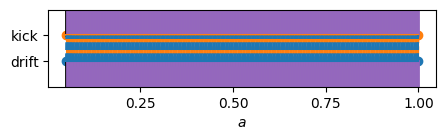

In [6]:
reset_plotting()  # Default style for Simbelmynë
generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)
generate_sim_params(p3m_params, ICs_path, wd, simdir, file_ext, force)
setup_plotting()  # Reset plotting style for this project

In [ ]:
TS = P3MTimeStepping.read(wd + file_ext + "_ts_p3m.h5" if file_ext else wd + "ts_p3m.h5")
aiDrift = TS.aiDrift
nsteps = TS.nsteps

[02:18:47|STATUS    ]|Read custom timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook7/ts_p3m.h5'...
[02:18:47|STATUS    ]|Read custom timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook7/ts_p3m.h5' done.


### Generate the initial phase

In [8]:
generate_white_noise_Field(
    L=L,
    size=N,
    corner=corner,
    seedphase=BASELINE_SEEDPHASE,
    fname_whitenoise=input_white_noise_file,
    seedname_whitenoise=input_seed_phase_file,
    force_phase=force,
)

### Generating the input power spectrum

In [9]:
# If cosmo["WhichSpectrum"] == "class", then classy is required.
if not isfile(input_power_file) or force:
    Pk = PowerSpectrum(L, L, L, N, N, N, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[02:18:47|STATUS    ]|Setting up Fourier grid...
[02:18:47|STATUS    ]|Setting up Fourier grid done.
[02:18:47|STATUS    ]|Computing normalization of the power spectrum...
[02:18:47|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook7/input_power.h5'...
[02:18:47|STATUS    ]|Computing normalization of the power spectrum done.
[02:18:47|STATUS    ]|Computing power spectrum...
[02:18:47|STATUS    ]|Computing power spectrum done.
[02:18:47|DIAGNOSTIC]==|L0=64, L1=64, L2=64
[02:18:47|DIAGNOSTIC]==|N0=32, N1=32, N2=32, N2_HC=17, N_HC=17408, NUM_MODES=464
[02:18:47|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook7/input_power.h5' done.


## Running the simulations

In [10]:
run_simulation("lpt", lpt_params, wd, logdir)

[02:18:47|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook7/example_lpt.sbmy /Users/hoellinger/WIP3M/notebook7/logs/lpt.txt
[02:18:47|INFO      ]|
[02:18:47|INFO      ]|            .-~~-.--.
[02:18:47|INFO      ]|           :         )
[02:18:47|INFO      ]|     .~ ~ -.\       /.- ~~ .
[02:18:47|INFO      ]|     >       `.   .'       <
[02:18:47|INFO      ]|    (         .- -.         )
[02:18:47|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[02:18:47|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[02:18:47|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[02:18:47|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[02:18:47|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[02:18:47|INFO      ]|       

In [11]:
run_simulation("p3m", p3m_params, wd, logdir)

[02:18:47|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook7/example_p3m.sbmy /Users/hoellinger/WIP3M/notebook7/logs/p3m.txt
[02:18:47|INFO      ]|
[02:18:47|INFO      ]|            .-~~-.--.
[02:18:47|INFO      ]|           :         )
[02:18:47|INFO      ]|     .~ ~ -.\       /.- ~~ .
[02:18:47|INFO      ]|     >       `.   .'       <
[02:18:47|INFO      ]|    (         .- -.         )
[02:18:47|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[02:18:47|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[02:18:47|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[02:18:47|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[02:18:47|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[02:18:47|INFO      ]|       

In [12]:
a, _, _, _, _, da_p3m, da_p3m_fit, _, _, _ = np.loadtxt(
    OutputTimestepsLog[:-4] + "_custom.txt", delimiter=",", unpack=True, skiprows=0
)

[02:19:08|INFO      ]|(wip3m.plot_utils) Plotting timestep limiters from /Users/hoellinger/WIP3M/notebook7/timesteps_log.txt and /Users/hoellinger/WIP3M/notebook7/timesteps_log_custom.txt...
[02:19:08|INFO      ]|(wip3m.plot_utils) Plotting timestep limiters from /Users/hoellinger/WIP3M/notebook7/timesteps_log.txt and /Users/hoellinger/WIP3M/notebook7/timesteps_log_custom.txt done.


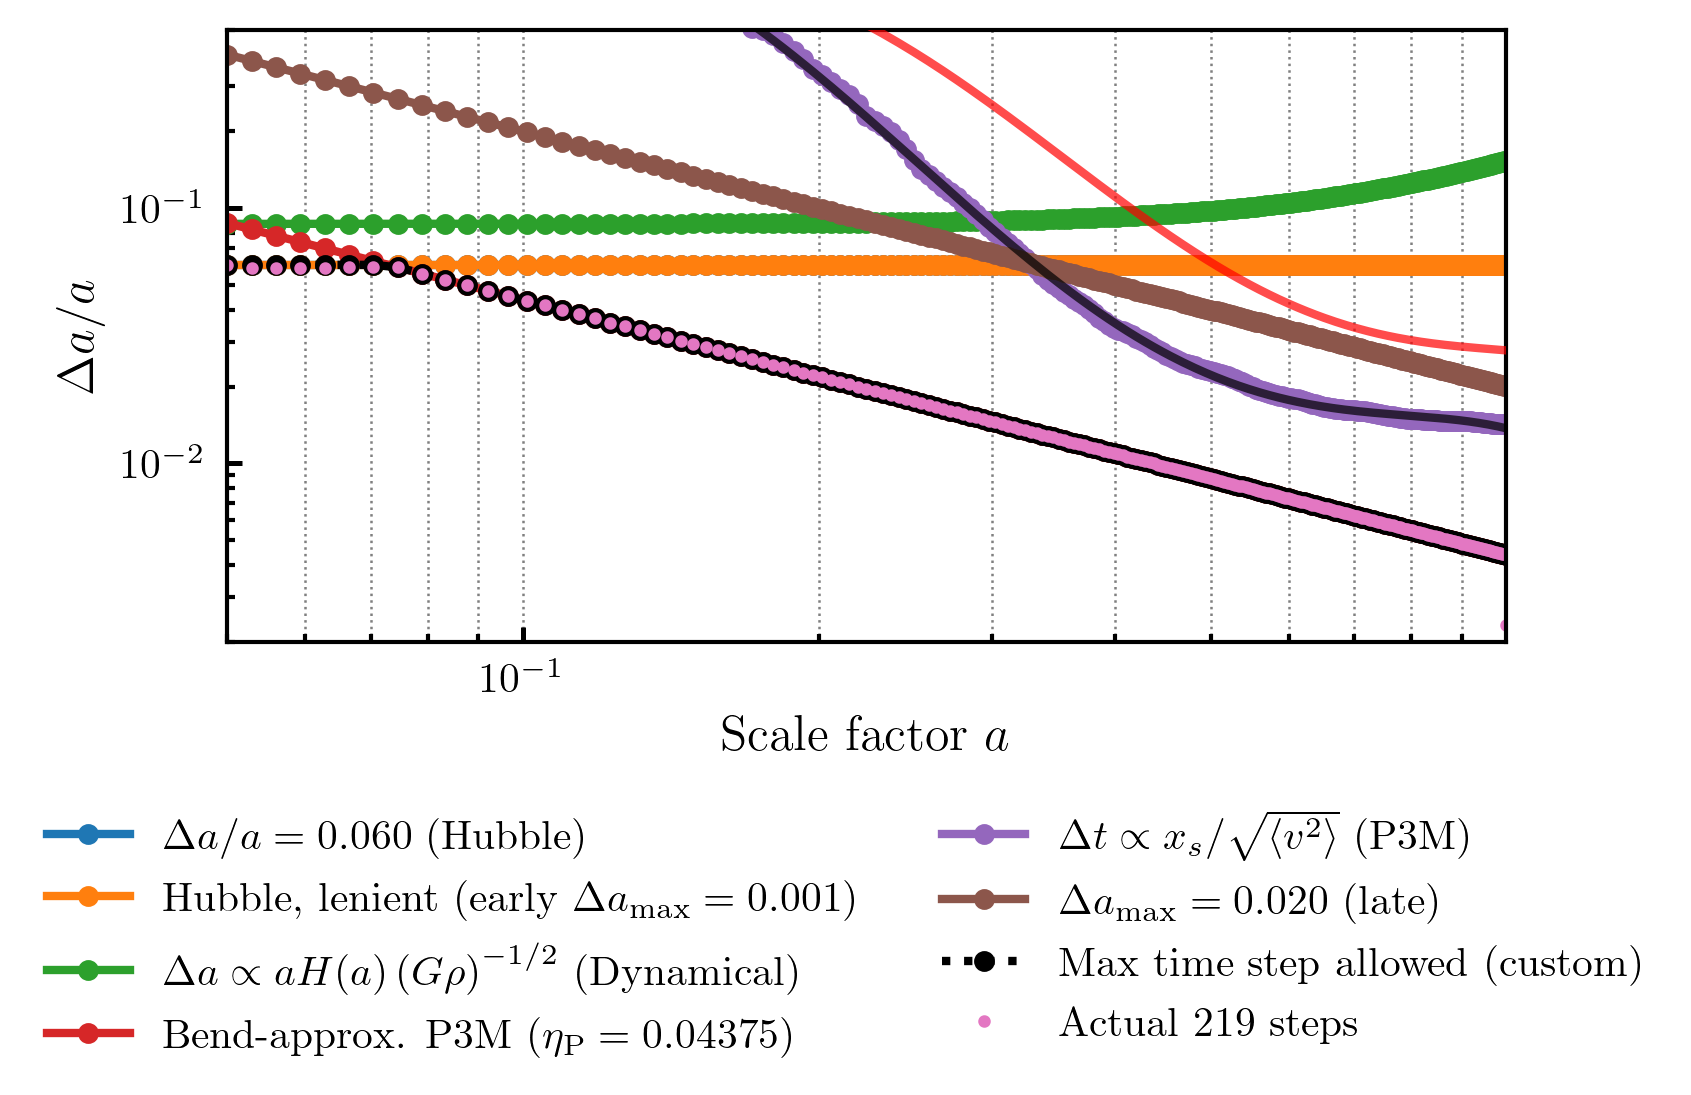

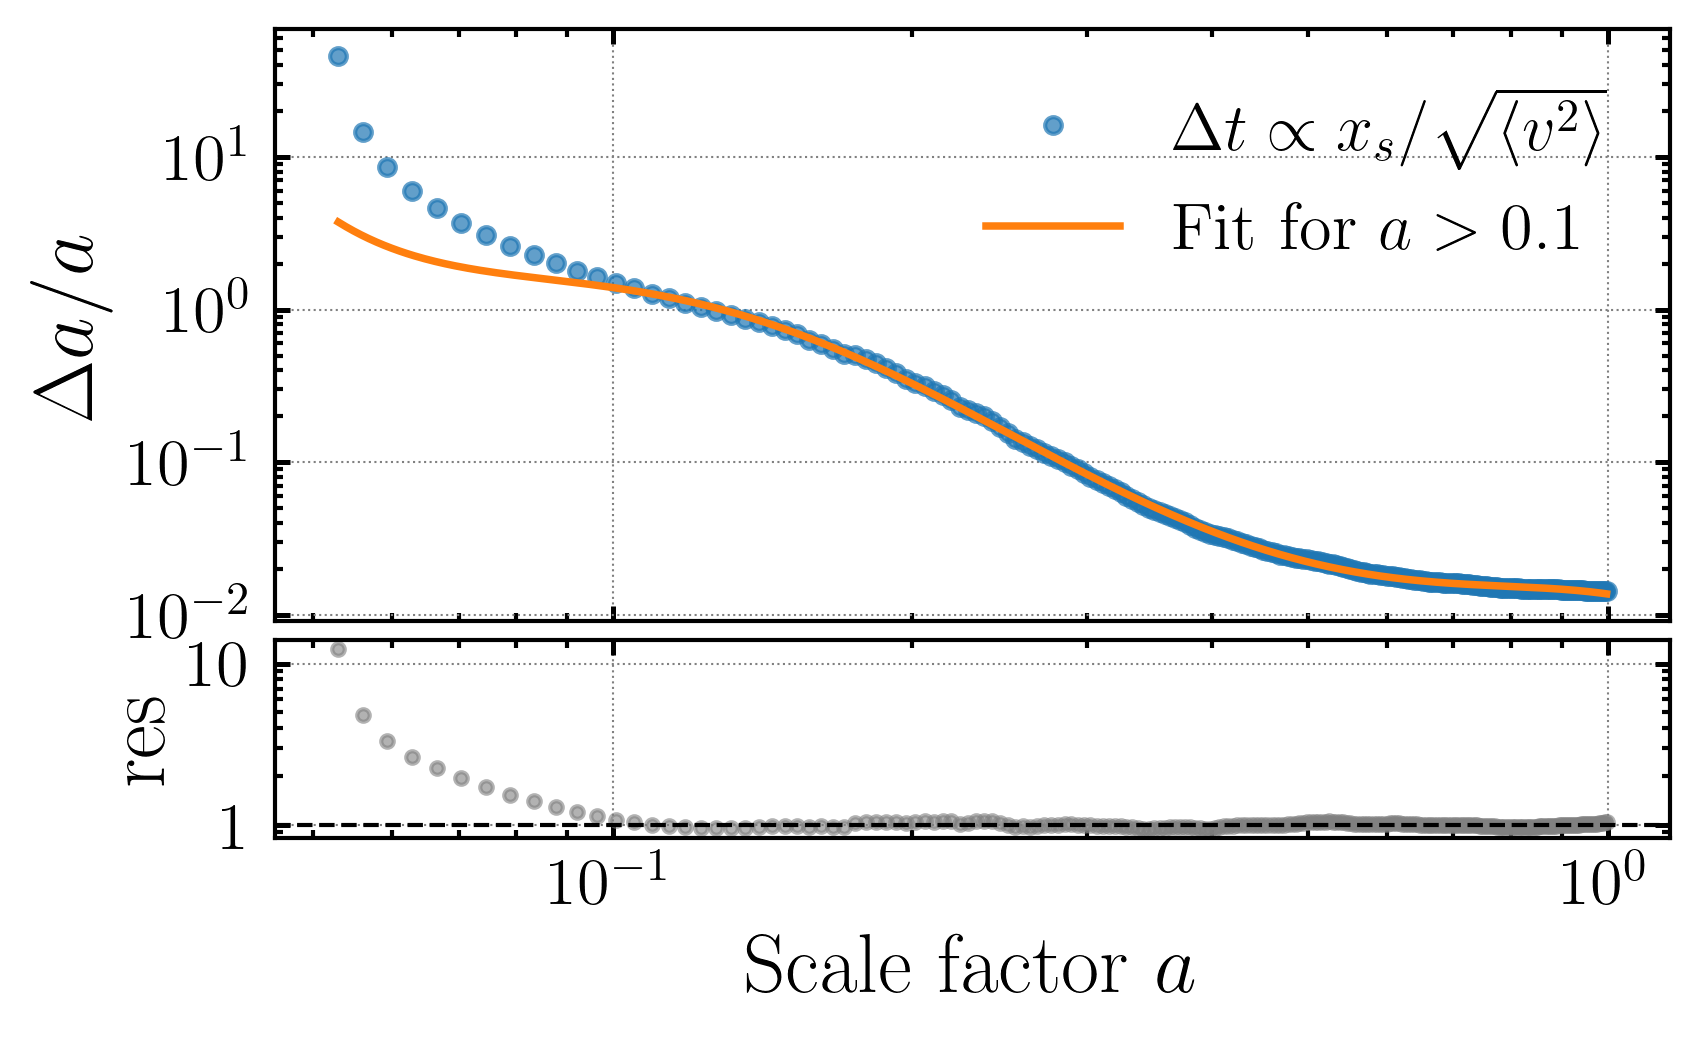

Coefficients of the polynomial fit (degree 5):
c[0] = -4.289415e+00
c[1] = -9.383043e-01
c[2] = -3.015398e+00
c[3] = -5.468808e+00
c[4] = -2.606665e+00
c[5] = -3.855979e-01


In [13]:
deg_fit = 5  # Degree of the polynomial fit for the P3M limiter
coeffs = fit_p3m(a, da_p3m, degree=deg_fit, amin=1e-1)

plot_custom_timestepping_diagnostics(
    log_path=OutputTimestepsLog,
    aiDrift=aiDrift,
    TimeStepDistribution=3,
    nsteps=nsteps,
    ymin=2e-3,
    ymax=0.5,
    fac_hubble=fac_hubble,
    fac_bend=fac_bend,
    da_max_early=da_early,
    da_max_late=DEFAULT_DA_MAX_LATE_CUSTOM,
    show=False,
)
plt.plot(a, da_p3m_fit/a, label="P3M limiter", color="red", alpha=0.7, zorder=10)
fit_interp = evaluate_polynomial_log(coeffs, a)
plt.plot(a, fit_interp, label=r"$\Delta t \propto x_s/\sqrt{\langle v^2 \rangle}$", color="black", alpha=0.7, zorder=10)
plt.show()

plot_p3m(a, da_p3m, coeffs, amin_fit=1e-1, amin_plot=5e-2)
print(f"Coefficients of the polynomial fit (degree {deg_fit}):")
for i, coeff in enumerate(coeffs):
    print(f"c[{i}] = {coeff:.6e}")

In [14]:
# Delta a/a = cst => da = cst * a
cst = (aiDrift[-2]-aiDrift[-3]) / aiDrift[-3]

# a_nsteps = aiDrift[0] * (1 + cst)**nsteps
# 1 = a_nsteps => 1 = aiDrift[0] * (1 + cst)**nsteps
nsteps_needed = int(np.ceil(np.log(af/aiDrift[0]) / np.log(1 + cst)))
print(f"Number of log steps needed to reach af={af} from ai={aiDrift[0]}: {nsteps_needed}")

Number of log steps needed to reach af=1.0 from ai=0.05: 679
